rendu: zip

final: fcihier a anoter ( text et mettre les labels)

repport : pdf, on vas dans le concret ( moins de blabla)
  -  carnet d'experience ( ce qu'on a tester)
  -  expliciter ce qui n'a pas marché
  -  essayer de faire des conclusion

Presentation:
  - parler d'un truc intéressant et parler rapidement (cross vs grip) 5 a 10 max


date d'envoi max 04/07
mail : @universite-paris-saclay

### **1. Importation des librairies**

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from collections import Counter

### **2. Lecture des données**

In [2]:
# from google.colab import files

# uploaded = files.upload()


In [3]:
os.listdir('.')

['Copy_of_cross+hierarchical.ipynb', 'README.md', '.git', 'train.txt']

In [4]:
df = pd.read_csv('train.txt', sep='\t', header=None)

In [5]:
def extract_country_and_text(row):
    match = re.match(r'\((.*?)\)(.*)', row)
    if match:
        country_code = match.group(1)
        text = match.group(2)
        return pd.Series([country_code, text])
    else:
        return pd.Series(['', row])

df[['country_code', 'text']] = df.iloc[:, 0].apply(extract_country_and_text)

df['country_code'].value_counts()

country_code
GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: count, dtype: int64

### **Utils**

#### models & vectorizers

In [6]:
new_mapping_list4 = {'HIN+TEL':0, 'KOR+CHI+JPN':1, 'FRE+SPA+ITA+GER':2,'ARA+TUR':3}

In [7]:
# vectorizers
vectorizers = {
  'vectorizer_BOW' : CountVectorizer(), # default=(1, 1)
  'vectorizer_TF_IDF' : TfidfVectorizer(), #default=(1, 1)
  'vectorizer_BOW_bigram' : CountVectorizer(ngram_range=(1, 2)),
  'vectorizer_TF_IDF_bigram' : TfidfVectorizer(ngram_range=(1, 2)),
}

# Modèles de classification
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'SVM': SVC()
}

#### Balance data
- each group same number of item
- in each group: each country same number of item

In [8]:
import pandas as pd

def balance_dataset_groups(df):
    balanced_df = pd.DataFrame(columns=df.columns)

    # Determine the minimum number of samples among all groups
    min_samples_per_group = df['group'].value_counts().min()

    # Iterate over each group in the dataset
    for group_name, group_data in df.groupby('group'):
        # Sample the minimum number of samples for this group
        sampled_group_data = group_data.sample(min_samples_per_group, replace=False)

        # Determine the minimum number of samples among all subgroups within this group
        min_samples_per_subgroup = min_samples_per_group // len(group_data['country_code'].unique())

        # Iterate over each subgroup within this group
        for subgroup_name, subgroup_data in sampled_group_data.groupby('country_code'):
            # Determine the number of samples in this subgroup
            subgroup_size = len(subgroup_data)

            # If the subgroup has fewer samples than required, sample with replacement
            if subgroup_size < min_samples_per_subgroup:
                sampled_subgroup_data = subgroup_data.sample(min_samples_per_subgroup, replace=True)
            else:
                sampled_subgroup_data = subgroup_data.sample(min_samples_per_subgroup, replace=False)

            # Append the sampled subgroup data to the balanced dataset
            balanced_df = pd.concat([balanced_df, sampled_subgroup_data])

    # Reset the index of the balanced DataFrame
    balanced_df.reset_index(drop=True, inplace=True)

    return balanced_df


#### Fonctions d'évaluations et matrice de confusion :

In [9]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_model_performance_detailed(mapping_list, model, model_name, method_name, train, test, y_train, y_test):
    model.fit(train, y_train)
    predictions = model.predict(test)

    # Metrics for each label
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
    metrics_df = pd.DataFrame({'Label': list(mapping_list.keys()),
                               'Precision': precision,
                               'Recall': recall,
                               'F1 Score': f1})

    # Global (macro) metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions)

    print(f"{model_name} ({method_name}) - Overall Metrics:\n- Accuracy: {accuracy:.4f}\n- Precision (Macro): {precision_macro:.4f}\n- Recall (Macro): {recall_macro:.4f}\n- F1 (Macro): {f1_macro:.4f}\n")

    print(f"{model_name} ({method_name}) - Metrics by Label:")
    print(metrics_df.to_string(index=False))


    cm = confusion_matrix(y_test, predictions)

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=list(mapping_list.keys()), yticklabels=list(mapping_list.keys()))
    plt.title(f"Confusion Matrix - {model_name} ({method_name})")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    return model


#### extract country and text

In [10]:
df.dropna(subset=['country_code'], inplace=True)
df.shape

# All texts are labeled

(9900, 3)

In [11]:
def extract_country_and_text(row):
    match = re.match(r'\((.*?)\)(.*)', row)
    if match:
        country_code = match.group(1)
        text = match.group(2)
        return pd.Series([country_code, text])
    else:
        return pd.Series(['', row])

df[['country_code', 'text']] = df.iloc[:, 0].apply(extract_country_and_text)

df['country_code'].value_counts()

country_code
GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: count, dtype: int64

#### create groups

In [12]:
def create_group(df):
  # Créez une nouvelle colonne 'Country_Code_New4' en copiant 'Country_Code'
  df['group'] = df['country_code']

  df.loc[df['country_code'].isin(['TEL', 'HIN']), 'group']  = 'HIN+TEL'
  df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'group'] = 'KOR+CHI+JPN'
  df.loc[df['country_code'].isin(['FRE', 'SPA','ITA','GER']), 'group'] = 'FRE+SPA+ITA+GER'
  df.loc[df['country_code'].isin(['ARA', 'TUR']), 'group'] = 'ARA+TUR'

  return df

In [13]:
create_group(df)

,0,country_code,text,group
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...,FRE+SPA+ITA+GER
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you...",ARA+TUR
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...,KOR+CHI+JPN
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...,HIN+TEL
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...,ARA+TUR
...,...,...,...,...
9895,"(CHI) Nowadays , more and more people go abroa...",CHI,"Nowadays , more and more people go abroad , n...",KOR+CHI+JPN
9896,(KOR) In accomplishing something that is risky...,KOR,In accomplishing something that is risky come...,KOR+CHI+JPN
9897,"(SPA) At the beginning of the 21st century , t...",SPA,"At the beginning of the 21st century , the in...",FRE+SPA+ITA+GER
9898,(HIN) The number of cars in use across the wor...,HIN,The number of cars in use across the world ha...,HIN+TEL


#### groups_dataframes

In [14]:
# get Dict by groups
def create_groups_dataframes(df):
  groups_labels = {'HIN+TEL', 'KOR+CHI+JPN', 'FRE+SPA+ITA+GER','ARA+TUR'}
  groups_dataframes = {}

  for label in groups_labels:
      label_df = df[df['group'] == label]  # Replace 'label_column' with the actual column name
      groups_dataframes[label] = label_df

  return groups_dataframes

In [15]:
# get dict by country in each group
def create_1_group_dataframes(df, country_labels):
  groups_dataframes = {}
  for label in country_labels:
      label_df = df[df['country_code'] == label]  # Replace 'label_column' with the actual column name
      groups_dataframes[label] = label_df

  return groups_dataframes

#### shuffle_rows

In [16]:
def shuffle_rows(dfs): # mélange des données
    i = 0
    for df in dfs:
      dfs[i] = df.sample(frac = 1, random_state=42)
      i += 1

#### train

In [17]:
def train(mapping_list, df, save_model_vectorizer):
  X = df['text']
  y_grouped4 = df['group'].map(mapping_list)

  # Entraînement et évaluation des modèles
  for model_name, model in models.items():
      for vectorizer_name, vectorizer in vectorizers.items():
          print('========================= Model: {}; vectorizer: {} ========================='.format(model_name, vectorizer))
          train, test, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)
          model_save = evaluate_model_performance_detailed(new_mapping_list4, model, model_name, vectorizer_name, train, test, y_train_grouped4, y_test_grouped4)
          save_model_vectorizer[model_name+'-'+vectorizer_name]  = (model_save, vectorizer)

In [18]:
def train_1_group(mapping_list, df, save_model_vectorizer):
  X = df['text']
  print(X.shape)
  y_grouped4 = df['country_code'].map(mapping_list)
  print(y_grouped4.shape)

  # Entraînement et évaluation des modèles
  for model_name, model in models.items():
      for vectorizer_name, vectorizer in vectorizers.items():
          print('========================= Model: {}; vectorizer: {} ========================='.format(model_name, vectorizer))
          train, test, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)
          model_save = evaluate_model_performance_detailed(mapping_list, model, model_name, vectorizer_name, train, test, y_train_grouped4, y_test_grouped4)
          save_model_vectorizer[model_name+'-'+vectorizer_name]  = (model_save, vectorizer)

#### best model

In [19]:
def best(results):
  best = max(results, key=lambda key: results[key]['test_accuracy'])
  return best

##  **3. Regroupement**:

  - **Groupe 01**: TEL, HIN
  - **Groupe 02**: KOR, CHI, JPN
  - **Groupe 03**: FRE, SPA, ITA, GER
  - **Groupe 04**: ARA, TUR

#### Unbalanced

========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================
Logistic Regression (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.8505
- Precision (Macro): 0.8385
- Recall (Macro): 0.8406
- F1 (Macro): 0.8394

Logistic Regression (vectorizer_BOW) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.879781 0.907042  0.893204
    KOR+CHI+JPN   0.870036 0.857651  0.863799
FRE+SPA+ITA+GER   0.878621 0.878621  0.878621
        ARA+TUR   0.725373 0.718935  0.722140


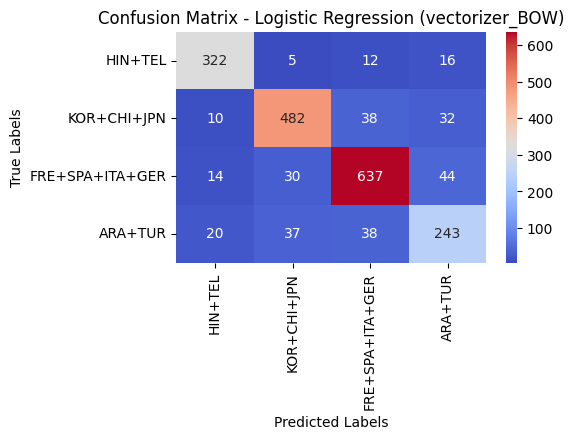

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer() =========================
Logistic Regression (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.8348
- Precision (Macro): 0.8365
- Recall (Macro): 0.8044
- F1 (Macro): 0.8144

Logistic Regression (vectorizer_TF_IDF) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.887608 0.867606  0.877493
    KOR+CHI+JPN   0.833904 0.866548  0.849913
FRE+SPA+ITA+GER   0.822660 0.921379  0.869226
        ARA+TUR   0.801688 0.562130  0.660870


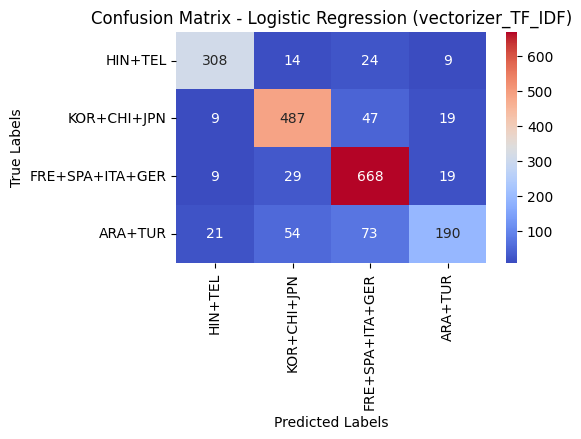

========================= Model: Logistic Regression; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.8818
- Precision (Macro): 0.8750
- Recall (Macro): 0.8697
- F1 (Macro): 0.8722

Logistic Regression (vectorizer_BOW_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.929379 0.926761  0.928068
    KOR+CHI+JPN   0.892665 0.887900  0.890277
FRE+SPA+ITA+GER   0.892761 0.918621  0.905506
        ARA+TUR   0.785047 0.745562  0.764795


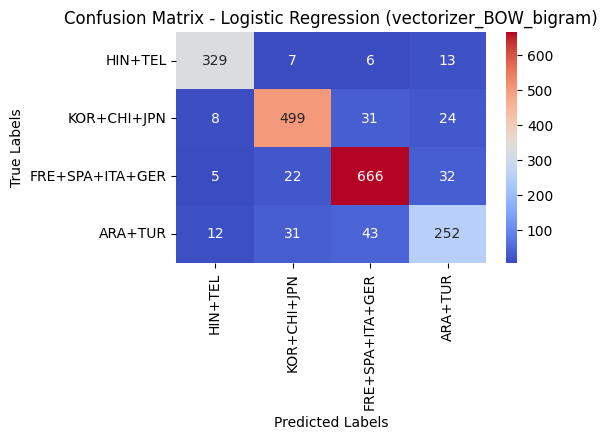

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.8288
- Precision (Macro): 0.8479
- Recall (Macro): 0.7875
- F1 (Macro): 0.8023

Logistic Regression (vectorizer_TF_IDF_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.912121 0.847887  0.878832
    KOR+CHI+JPN   0.822635 0.866548  0.844021
FRE+SPA+ITA+GER   0.793779 0.950345  0.865035
        ARA+TUR   0.863158 0.485207  0.621212


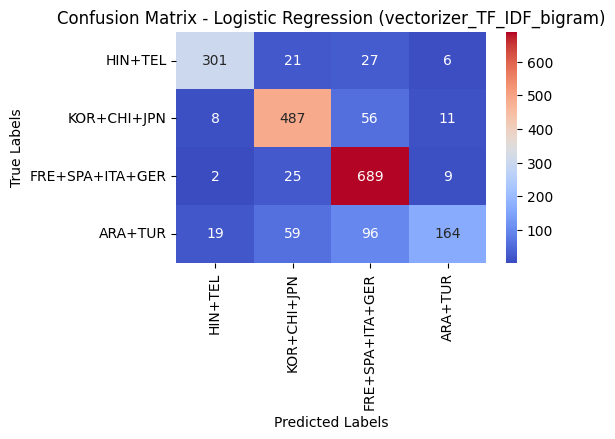

========================= Model: SVM; vectorizer: CountVectorizer() =========================
SVM (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.7909
- Precision (Macro): 0.7870
- Recall (Macro): 0.7559
- F1 (Macro): 0.7648

SVM (vectorizer_BOW) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.855882 0.819718  0.837410
    KOR+CHI+JPN   0.783193 0.829181  0.805532
FRE+SPA+ITA+GER   0.789474 0.889655  0.836576
        ARA+TUR   0.719298 0.485207  0.579505


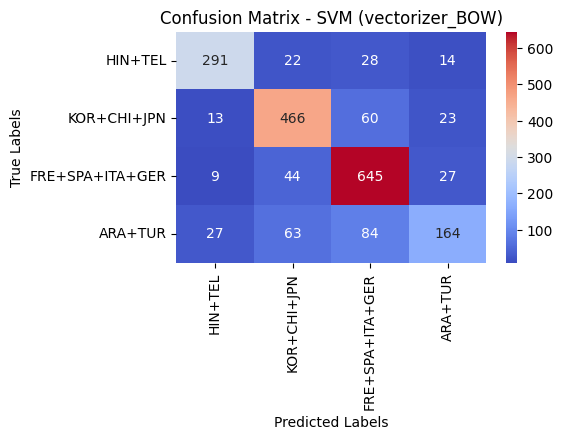

========================= Model: SVM; vectorizer: TfidfVectorizer() =========================
SVM (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.8571
- Precision (Macro): 0.8608
- Recall (Macro): 0.8307
- F1 (Macro): 0.8409

SVM (vectorizer_TF_IDF) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.927326 0.898592  0.912732
    KOR+CHI+JPN   0.850085 0.887900  0.868581
FRE+SPA+ITA+GER   0.842500 0.929655  0.883934
        ARA+TUR   0.823293 0.606509  0.698467


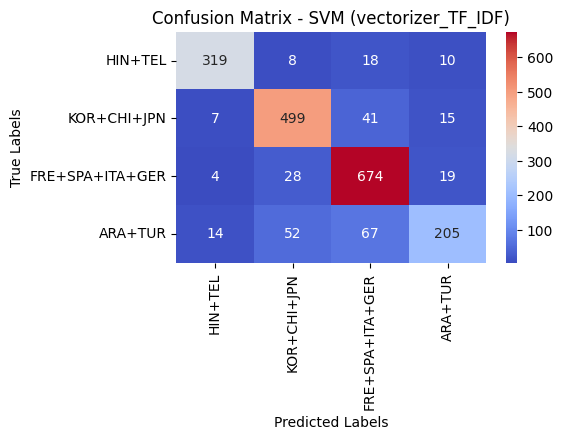

========================= Model: SVM; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.8167
- Precision (Macro): 0.8141
- Recall (Macro): 0.7844
- F1 (Macro): 0.7929

SVM (vectorizer_BOW_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.876081 0.856338  0.866097
    KOR+CHI+JPN   0.805695 0.855872  0.830026
FRE+SPA+ITA+GER   0.815920 0.904828  0.858077
        ARA+TUR   0.758621 0.520710  0.617544


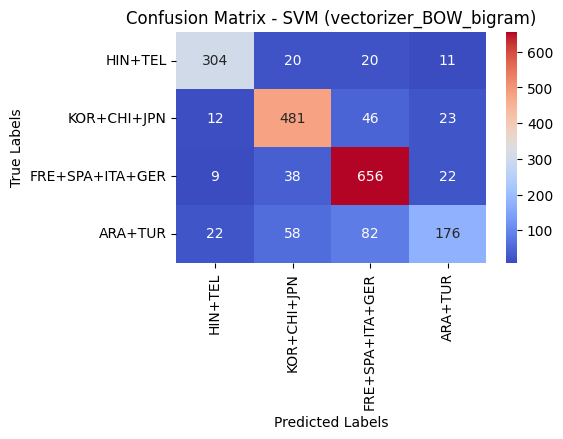

========================= Model: SVM; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.8333
- Precision (Macro): 0.8576
- Recall (Macro): 0.7916
- F1 (Macro): 0.8078

SVM (vectorizer_TF_IDF_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.938650 0.861972  0.898678
    KOR+CHI+JPN   0.835334 0.866548  0.850655
FRE+SPA+ITA+GER   0.785311 0.958621  0.863354
        ARA+TUR   0.870968 0.479290  0.618321


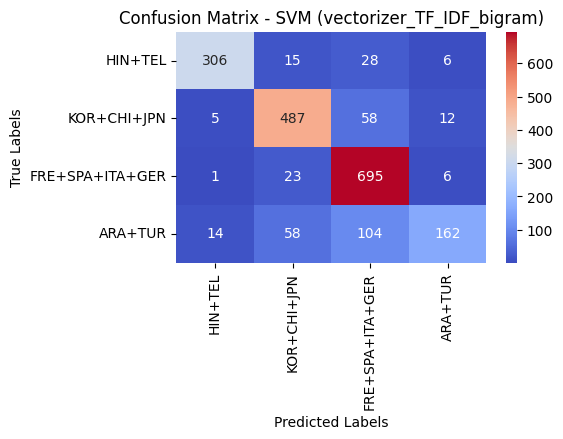

In [ ]:
unbalanced_models = {}
train(new_mapping_list4, df, unbalanced_models)

Best model

In [ ]:
unbalanced_models

{'Logistic Regression-vectorizer_BOW': (LogisticRegression(max_iter=2000),
  CountVectorizer()),
 'Logistic Regression-vectorizer_TF_IDF': (LogisticRegression(max_iter=2000),
  TfidfVectorizer()),
 'Logistic Regression-vectorizer_BOW_bigram': (LogisticRegression(max_iter=2000),
  CountVectorizer(ngram_range=(1, 2))),
 'Logistic Regression-vectorizer_TF_IDF_bigram': (LogisticRegression(max_iter=2000),
  TfidfVectorizer(ngram_range=(1, 2))),
 'SVM-vectorizer_BOW': (SVC(), CountVectorizer()),
 'SVM-vectorizer_TF_IDF': (SVC(), TfidfVectorizer()),
 'SVM-vectorizer_BOW_bigram': (SVC(), CountVectorizer(ngram_range=(1, 2))),
 'SVM-vectorizer_TF_IDF_bigram': (SVC(), TfidfVectorizer(ngram_range=(1, 2)))}

#### Balanced

In [20]:
# Balance the dataset
balanced_df = balance_dataset_groups(df)

# Verify the balance
print(balanced_df['group'].value_counts())
print(balanced_df.groupby(['group', 'country_code']).size())

group
ARA+TUR            1800
FRE+SPA+ITA+GER    1800
HIN+TEL            1800
KOR+CHI+JPN        1800
Name: count, dtype: int64
group            country_code
ARA+TUR          ARA             900
                 TUR             900
FRE+SPA+ITA+GER  FRE             450
                 GER             450
                 ITA             450
                 SPA             450
HIN+TEL          HIN             900
                 TEL             900
KOR+CHI+JPN      CHI             600
                 JPN             600
                 KOR             600
dtype: int64


========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================
Logistic Regression (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.8368
- Precision (Macro): 0.8374
- Recall (Macro): 0.8374
- F1 (Macro): 0.8369

Logistic Regression (vectorizer_BOW) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.927536 0.881543  0.903955
    KOR+CHI+JPN   0.840731 0.896936  0.867925
FRE+SPA+ITA+GER   0.789625 0.810651  0.800000
        ARA+TUR   0.791781 0.760526  0.775839


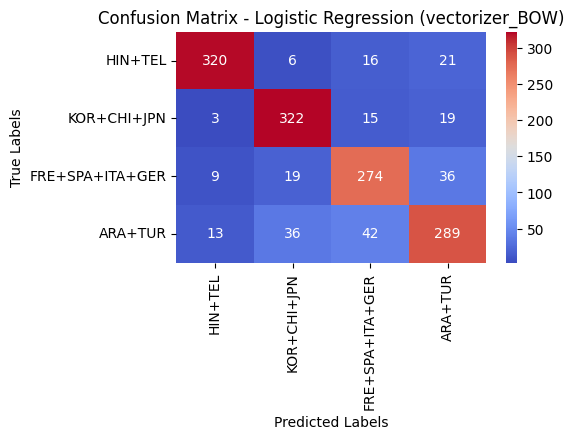

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer() =========================
Logistic Regression (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.8215
- Precision (Macro): 0.8207
- Recall (Macro): 0.8234
- F1 (Macro): 0.8205

Logistic Regression (vectorizer_TF_IDF) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.883784 0.900826  0.892224
    KOR+CHI+JPN   0.804569 0.883008  0.841965
FRE+SPA+ITA+GER   0.799427 0.825444  0.812227
        ARA+TUR   0.795107 0.684211  0.735502


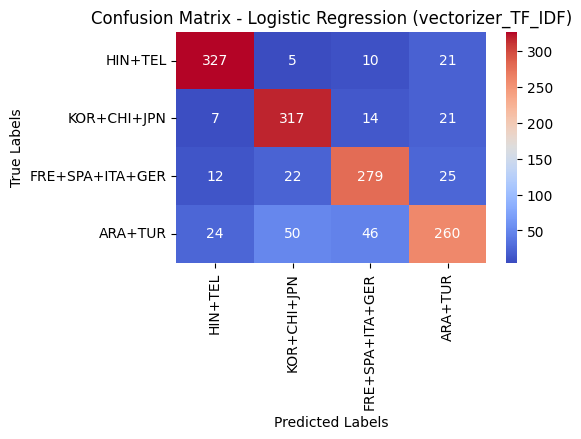

========================= Model: Logistic Regression; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.8736
- Precision (Macro): 0.8735
- Recall (Macro): 0.8742
- F1 (Macro): 0.8737

Logistic Regression (vectorizer_BOW_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.924370 0.909091  0.916667
    KOR+CHI+JPN   0.895161 0.927577  0.911081
FRE+SPA+ITA+GER   0.847507 0.855030  0.851252
        ARA+TUR   0.827027 0.805263  0.816000


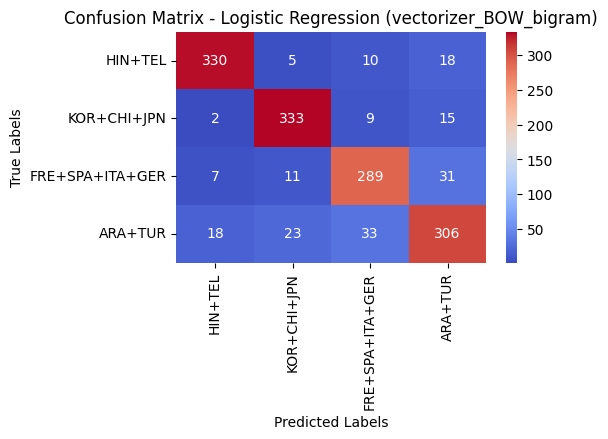

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.8431
- Precision (Macro): 0.8423
- Recall (Macro): 0.8452
- F1 (Macro): 0.8419

Logistic Regression (vectorizer_TF_IDF_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.890374 0.917355  0.903664
    KOR+CHI+JPN   0.843342 0.899721  0.870620
FRE+SPA+ITA+GER   0.806630 0.863905  0.834286
        ARA+TUR   0.828660 0.700000  0.758916


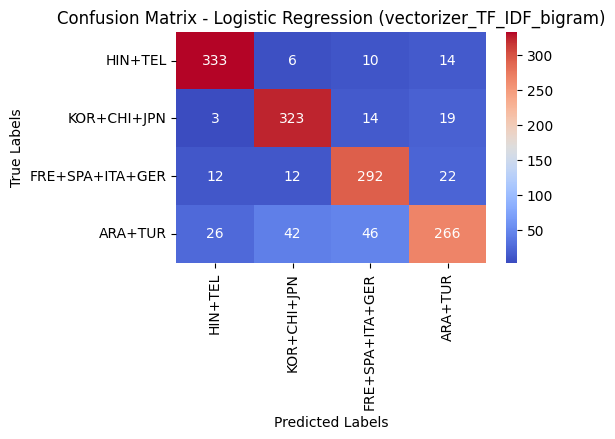

========================= Model: SVM; vectorizer: CountVectorizer() =========================
SVM (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.7778
- Precision (Macro): 0.7764
- Recall (Macro): 0.7799
- F1 (Macro): 0.7760

SVM (vectorizer_BOW) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.842541 0.840220  0.841379
    KOR+CHI+JPN   0.775061 0.883008  0.825521
FRE+SPA+ITA+GER   0.752874 0.775148  0.763848
        ARA+TUR   0.735202 0.621053  0.673324


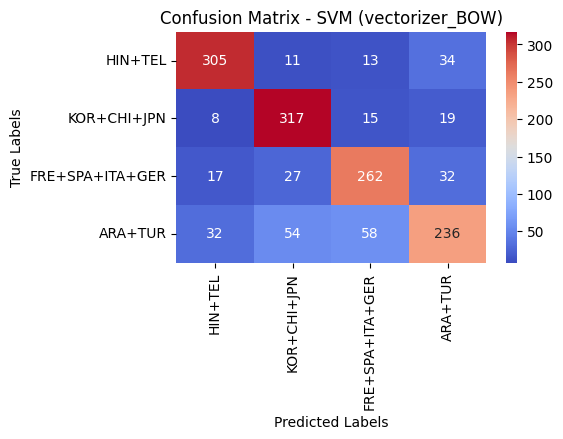

========================= Model: SVM; vectorizer: TfidfVectorizer() =========================
SVM (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.8465
- Precision (Macro): 0.8472
- Recall (Macro): 0.8475
- F1 (Macro): 0.8471

SVM (vectorizer_TF_IDF) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.928775 0.898072  0.913165
    KOR+CHI+JPN   0.851459 0.894150  0.872283
FRE+SPA+ITA+GER   0.827485 0.837278  0.832353
        ARA+TUR   0.781081 0.760526  0.770667


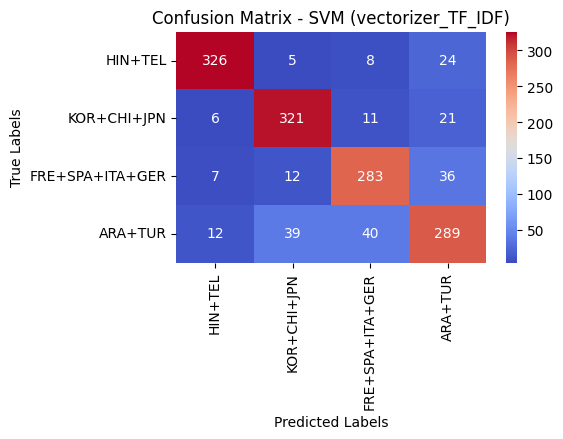

========================= Model: SVM; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.8111
- Precision (Macro): 0.8101
- Recall (Macro): 0.8128
- F1 (Macro): 0.8103

SVM (vectorizer_BOW_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.868132 0.870523  0.869326
    KOR+CHI+JPN   0.811705 0.888579  0.848404
FRE+SPA+ITA+GER   0.789625 0.810651  0.800000
        ARA+TUR   0.770833 0.681579  0.723464


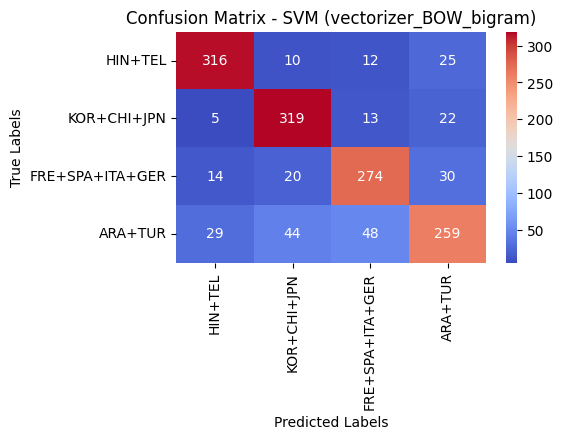

========================= Model: SVM; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.8500
- Precision (Macro): 0.8527
- Recall (Macro): 0.8500
- F1 (Macro): 0.8510

SVM (vectorizer_TF_IDF_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.909091 0.909091  0.909091
    KOR+CHI+JPN   0.889855 0.855153  0.872159
FRE+SPA+ITA+GER   0.844985 0.822485  0.833583
        ARA+TUR   0.766749 0.813158  0.789272


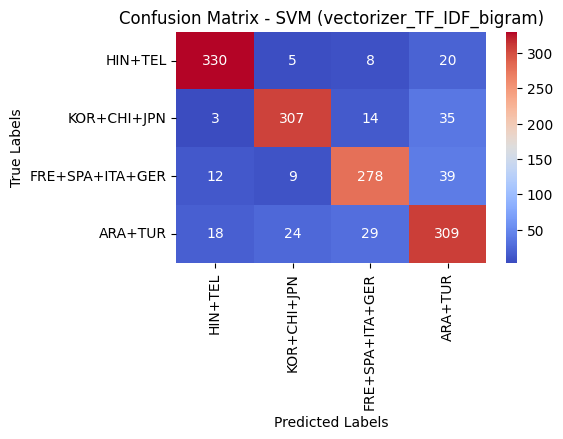

In [ ]:
balanced_models = {}
train(new_mapping_list4, balanced_df, balanced_models)

In [ ]:
balanced_models

{'Logistic Regression-vectorizer_BOW': (LogisticRegression(max_iter=2000),
  CountVectorizer()),
 'Logistic Regression-vectorizer_TF_IDF': (LogisticRegression(max_iter=2000),
  TfidfVectorizer()),
 'Logistic Regression-vectorizer_BOW_bigram': (LogisticRegression(max_iter=2000),
  CountVectorizer(ngram_range=(1, 2))),
 'Logistic Regression-vectorizer_TF_IDF_bigram': (LogisticRegression(max_iter=2000),
  TfidfVectorizer(ngram_range=(1, 2))),
 'SVM-vectorizer_BOW': (SVC(), CountVectorizer()),
 'SVM-vectorizer_TF_IDF': (SVC(), TfidfVectorizer()),
 'SVM-vectorizer_BOW_bigram': (SVC(), CountVectorizer(ngram_range=(1, 2))),
 'SVM-vectorizer_TF_IDF_bigram': (SVC(), TfidfVectorizer(ngram_range=(1, 2)))}

# 4. cross validation functions

##### Utils

In [21]:
# separate the dataframe into labels
balanced_df = balanced_df.iloc[: , 1:]

In [22]:
labels = {"GER","TUR","CHI","TEL","ARA","SPA","HIN","JPN","KOR","FRE","ITA"}

In [23]:
label_dataframes = {}

for label in labels:
    label_df = df[df['country_code'] == label]  # Replace 'label_column' with the actual column name
    label_dataframes[label] = label_df

In [24]:
groups_df = create_groups_dataframes(balanced_df)

In [25]:
groups_df.keys()

dict_keys(['HIN+TEL', 'ARA+TUR', 'FRE+SPA+ITA+GER', 'KOR+CHI+JPN'])

In [26]:
groups_df['HIN+TEL'].shape

(1800, 3)

##### splits

In [27]:
def splits(label_dataframes, split_nbr):
    size = 1800
    max = 100

    trains = []
    devs = []
    tests = []

    start = 0
    end = size // split_nbr if split_nbr != 0 and size // split_nbr < max else max

    while split_nbr != 0:
        split_nbr -= 1

        train_splits = []
        dev_splits = []
        test_splits = []

        for df in label_dataframes.values():
            test_split = df[start:end]
            dev_split = df[end:end + (end - start)]  # Set dev_split size to (end - start)
            train_split = df[end + (end - start):]    # The remaining data goes to test_split

            train_splits.append(train_split)
            dev_splits.append(dev_split)
            test_splits.append(test_split)

        trains.append(pd.concat(train_splits))
        devs.append(pd.concat(dev_splits))
        tests.append(pd.concat(test_splits))

        start = end
        end = start + (size // split_nbr) if split_nbr != 0 and (size // split_nbr) < max else (start + max)

    return trains, devs, tests


##### test indexes

In [28]:
def test_diffrent_indexes(dfs):
    # Initialize a variable to track if indexes are different
    different_indexes = False

    # Iterate through pairs of DataFrames and compare indexes
    for i in range(len(dfs) - 1):
        for j in range(i + 1, len(dfs)):
            if not dfs[i].index.equals(dfs[j].index):
                different_indexes = True
                break
        if different_indexes:
            break

    # Output the result
    if different_indexes:
        print("The DataFrames have different indexes.")
    else:
        print("The DataFrames have the same indexes.")

In [29]:
trains, devs, tests = splits(groups_df, 3)

In [30]:
test_diffrent_indexes(devs), test_diffrent_indexes(tests)

The DataFrames have different indexes.
The DataFrames have different indexes.


(None, None)

In [31]:
shuffle_rows(trains), shuffle_rows(tests), shuffle_rows(devs)

(None, None, None)

In [32]:
trains[0].shape[0], devs[0].shape[0], tests[0].shape[0],

(6400, 400, 400)

##### cross validation

In [33]:
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import time

def cross_validation(df, model, params, vectorizer, split=3):
    # split data: train, dev, test
    trains, devs, tests = splits(df, split)

    param_grid = ParameterGrid(params)
    results = {}

    for param in param_grid:
        iteration = 0
        accuracies = []
        test_accuracies=[]
        print(param)

        model.set_params(**param)  # set model parameters
        print(model)

        for train, dev, test in zip(trains, devs, tests):
            start = time.time()
            iteration += 1
            print(iteration)

            # Feature extraction for text
            vectorizer.fit(train['text'])
            X_train_text = vectorizer.transform(train['text'])
            X_dev_text = vectorizer.transform(dev['text'])
            X_test_text = vectorizer.transform(test['text'])


            # Train the model on the training set
            model.fit(X_train_text, train['group'])

            # Validate the model on the dev set
            accuracy = model.score(X_dev_text, dev['group'])
            accuracies.append(accuracy)

            # Evaluate the model on the test set
            test_accuracy = model.score(X_test_text, test['group'])
            test_accuracies.append(test_accuracy)

            print("Dev Accuracy= " + str(accuracy))
            print("Test Accuracy= " + str(test_accuracy))
            print("time spent=" + str((time.time()-start)/60))

        results[str(param)] = {
            "model": model.set_params(**param),
            "vectorizer": vectorizer,
            'dev_mean_accuracy': sum(accuracies) / len(accuracies),
            'test_accuracy': sum(test_accuracies) / len(test_accuracies),
        }

    return results

In [34]:

def cross_validation_1group(df, model, params, vectorizer, split=3):
    # split data: train, dev, test
    trains, devs, tests = splits(df, split)

    param_grid = ParameterGrid(params)
    results = {}

    for param in param_grid:
        iteration = 0
        accuracies = []
        test_accuracies=[]
        print(param)

        # Train the model on the training set
        model.set_params(**param)  # set model parameters
        print(model)

        for train, dev, test in zip(trains, devs, tests):
            start = time.time()
            iteration += 1
            print(iteration)

            # Feature extraction for text
            vectorizer.fit(train['text'])
            X_train_text = vectorizer.transform(train['text'])
            X_dev_text = vectorizer.transform(dev['text'])
            X_test_text = vectorizer.transform(test['text'])


            model.fit(X_train_text, train['country_code'])

            # Validate the model on the dev set
            accuracy = model.score(X_dev_text, dev['country_code'])
            accuracies.append(accuracy)

            # Evaluate the model on the test set
            test_accuracy = model.score(X_test_text, test['country_code'])
            test_accuracies.append(test_accuracy)

            print("Dev Accuracy= " + str(accuracy))
            print("Test Accuracy= " + str(test_accuracy))
            print("time spent=" + str((time.time()-start)/60))

        results[str(param)] = {
            "model": model.set_params(**param),
            "vectorizer": vectorizer,
            'dev_mean_accuracy': sum(accuracies) / len(accuracies),
            'test_accuracy': sum(test_accuracies) / len(test_accuracies),
        }

    return results

##### save & load model

In [35]:
import pickle

def save_model_vectorizer(model, vectorizer, model_name, vectorizer_name):
    pickle.dump(model, open(model_name, 'wb'))
    pickle.dump(vectorizer, open(vectorizer_name, 'wb'))

In [36]:
def load(filename):
    return  pickle.load(open(filename, 'rb'))

# 5. Cross validation

## Grids and models

In [39]:
lr_model = LogisticRegression()
lr_param_grid = {
    'penalty': ['l2'],  # Regularization penalty
    'C': [0.01, 1],  # Inverse regularization strength (reduced to two values)
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [1500],  # Maximum number of iterations (reduced to one value)
    'tol': [1e-4]  # Tolerance for stopping criteria (only one value)
}

##LogisticRegression



In [40]:
results = cross_validation(groups_df, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='liblinear')
1


Dev Accuracy= 0.8225
Test Accuracy= 0.8575
time spent=0.1917269746462504
2
Dev Accuracy= 0.7575
Test Accuracy= 0.8075
time spent=0.17932617664337158
{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='saga')
1
Dev Accuracy= 0.8175
Test Accuracy= 0.85
time spent=0.47606254418691
2
Dev Accuracy= 0.7425
Test Accuracy= 0.7875
time spent=0.4151090860366821
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.8525
Test Accuracy= 0.86
time spent=0.21919806400934855
2
Dev Accuracy= 0.7575
Test Accuracy= 0.8325
time spent=0.20974185864130657
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='saga')
1


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Dev Accuracy= 0.8375
Test Accuracy= 0.8425
time spent=2.986025063196818
2
Dev Accuracy= 0.75
Test Accuracy= 0.815
time spent=2.747281233469645


In [41]:
results

{"{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.79,
  'test_accuracy': 0.8325},
 "{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.78,
  'test_accuracy': 0.81875},
 "{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.8049999999999999,
  'test_accuracy': 0.84625},
 "{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
 

In [42]:
# Find the key with the best test accuracy
best_accuracy_key = max(results, key=lambda key: results[key]['test_accuracy'])
print("Key with best test accuracy:", best_accuracy_key)

Key with best test accuracy: {'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}


In [43]:
results[best_accuracy_key]["test_accuracy"]

0.84625

In [44]:
# cross validation model
M1 = results[best_accuracy_key]["model"]
V1 = results[best_accuracy_key]["vectorizer"]

In [45]:
save_model_vectorizer(M1, V1, "M1", "V1")

## RF


In [46]:
# # Initialize Random Forest Classifier
# from sklearn.ensemble import RandomForestClassifier
# rf_classifier = RandomForestClassifier(random_state=42)
# param_grid_rf_small = {
#     'n_estimators': [50, 100],  # Number of trees in the forest
#     'max_depth': [None, 10],       # Maximum depth of the tree
#     'min_samples_split': [2, 5],   # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2]      # Minimum number of samples required to be at a leaf node
# }

# results = cross_validation(groups_df, rf_classifier, param_grid_rf_small, vectorizer_TF_IDF,2)

# print(results)

In [47]:
# # Find the key with the best test accuracy
# best_accuracy_key = max(results, key=lambda key: results[key]['test_accuracy'])
# print("Key with best test accuracy:", best_accuracy_key)

## svc


In [48]:
# # Parameter grid for SVC
# param_grid_svc = {
#     'C': [0.1, 1, 10],                    # Regularization parameter
#     'kernel': ['linear', 'rbf'],  # Kernel type
#     'gamma': ['scale', 'auto'],           # Kernel coefficient
#     'degree': [2, 4]                   # Degree of the polynomial kernel
# }

In [49]:
# results = cross_validation(groups_df, SVC(), param_grid_svc, vectorizer_TF_IDF,2)
# print(results)

In [50]:
# # Find the key with the best test accuracy
# svc_best_accuracy_key = max(results, key=lambda key: results[key]['test_accuracy'])
# print("Key with best test accuracy:", svc_best_accuracy_key)

In [51]:
# from sklearn.svm import SVC

# # Define the parameters
# parameters = {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

# # Create the SVC model with the specified parameters
# svc_model = SVC(**parameters)

# # Now you can use this model for training and prediction


In [52]:
# # Balance the dataset
# balanced_df = balance_dataset_groups(df)

# # Verify the balance
# print(balanced_df['group'].value_counts())
# print(balanced_df.groupby(['group', 'country_code']).size())

# new_mapping_list4 = {'HIN+TEL':0, 'KOR+CHI+JPN':1, 'FRE+SPA+ITA+GER':2,'ARA+TUR':3}

# X = balanced_df['text']
# y_grouped4 = balanced_df['group'].map(new_mapping_list4)

# # Split data avec y_grouped4
# train, test, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer_TF_IDF.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)
# evaluate_model_performance_detailed(new_mapping_list4, svc_model , "svc_model", "TF-IDF", train, test, y_train_grouped4, y_test_grouped4)

## DT


In [53]:
# from sklearn.tree import DecisionTreeClassifier

# param_grid_dt = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

In [54]:
# results = cross_validation(groups_df, DecisionTreeClassifier(), param_grid_dt, vectorizer_TF_IDF,2)
# print(results)

# cross For specialized model

## Utils

#### extract groups

In [55]:
def extract_group(df, group):
  return df[df['group'] == group]

### mapping country

In [56]:
def mapping(df, mapping):
  df['country_code'].map(mapping)

## Model for  Groupe 1 HIN+TEL


In [57]:
df_g1 = extract_group(df, 'HIN+TEL')

In [58]:
df_g1

,0,country_code,text,group
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...,HIN+TEL
8,"(HIN) In the era of science and technology , t...",HIN,"In the era of science and technology , the pe...",HIN+TEL
21,(TEL) Yup ! i do agree with is statement that ...,TEL,Yup ! i do agree with is statement that most ...,HIN+TEL
26,(TEL) I do agree with the satement that `` You...,TEL,I do agree with the satement that `` Young pe...,HIN+TEL
37,(HIN) Everybody has its own point of view on a...,HIN,Everybody has its own point of view on a cert...,HIN+TEL
...,...,...,...,...
9882,(HIN) I agree with the opinion thjat young pro...,HIN,I agree with the opinion thjat young prople o...,HIN+TEL
9886,(TEL) yes i agree with the statemet given abov...,TEL,yes i agree with the statemet given above . A...,HIN+TEL
9889,(HIN) I support the argument that young people...,HIN,I support the argument that young people do n...,HIN+TEL
9890,(HIN) This is a difficult topis as both travel...,HIN,This is a difficult topis as both travelling ...,HIN+TEL


#### train

(1800,)
(1800,)
========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================
Logistic Regression (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.7639
- Precision (Macro): 0.7652
- Recall (Macro): 0.7644
- F1 (Macro): 0.7638

Logistic Regression (vectorizer_BOW) - Metrics by Label:
Label  Precision  Recall  F1 Score
  HIN   0.742105 0.79661  0.768392
  TEL   0.788235 0.73224  0.759207


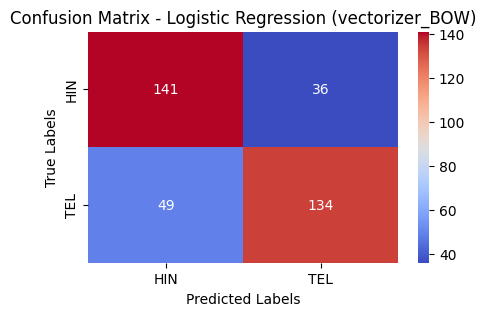

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer() =========================
Logistic Regression (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.7528
- Precision (Macro): 0.7529
- Recall (Macro): 0.7529
- F1 (Macro): 0.7528

Logistic Regression (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.741758 0.762712  0.752089
  TEL   0.764045 0.743169  0.753463


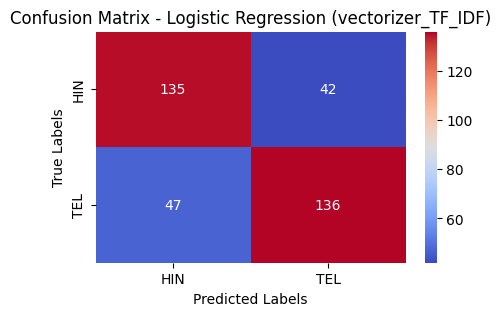

========================= Model: Logistic Regression; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.7694
- Precision (Macro): 0.7712
- Recall (Macro): 0.7701
- F1 (Macro): 0.7693

Logistic Regression (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision  Recall  F1 Score
  HIN   0.744792 0.80791  0.775068
  TEL   0.797619 0.73224  0.763533


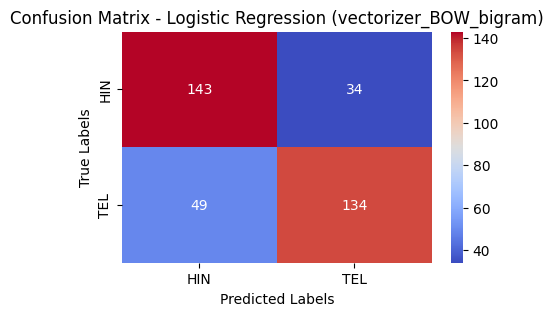

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.7667
- Precision (Macro): 0.7669
- Recall (Macro): 0.7669
- F1 (Macro): 0.7667

Logistic Regression (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.754098 0.779661  0.766667
  TEL   0.779661 0.754098  0.766667


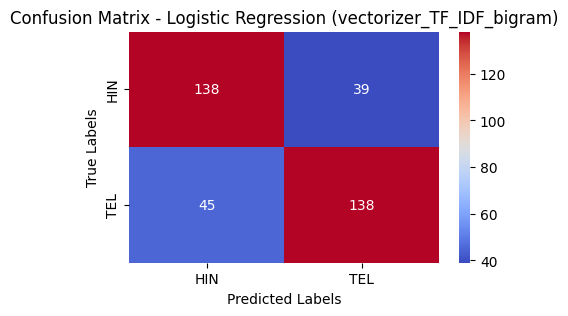

========================= Model: SVM; vectorizer: CountVectorizer() =========================
SVM (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.7250
- Precision (Macro): 0.7251
- Recall (Macro): 0.7252
- F1 (Macro): 0.7250

SVM (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.714286 0.734463  0.724234
  TEL   0.735955 0.715847  0.725762


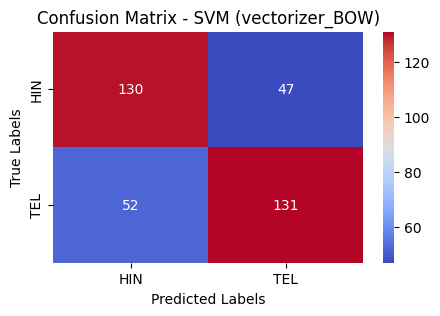

========================= Model: SVM; vectorizer: TfidfVectorizer() =========================
SVM (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.7639
- Precision (Macro): 0.7667
- Recall (Macro): 0.7647
- F1 (Macro): 0.7636

SVM (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.734694 0.813559  0.772118
  TEL   0.798780 0.715847  0.755043


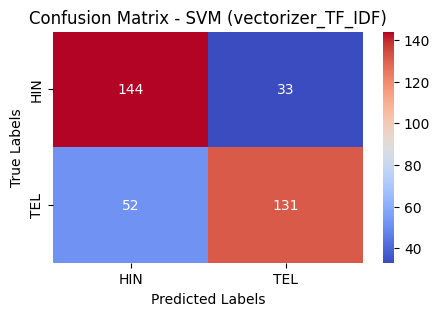

========================= Model: SVM; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.7528
- Precision (Macro): 0.7536
- Recall (Macro): 0.7532
- F1 (Macro): 0.7527

SVM (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.734043 0.779661  0.756164
  TEL   0.773256 0.726776  0.749296


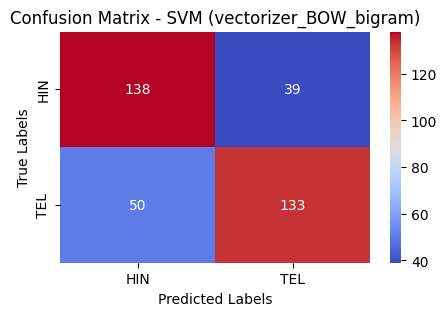

========================= Model: SVM; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.7583
- Precision (Macro): 0.7633
- Recall (Macro): 0.7594
- F1 (Macro): 0.7577

SVM (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.722772 0.824859  0.770449
  TEL   0.803797 0.693989  0.744868


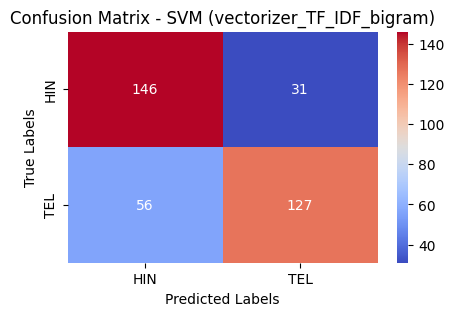

In [59]:
models_g1 = {}
mapping_list1 = {'HIN':0,'TEL':1}
train_1_group(mapping_list1, df_g1, models_g1) # mapping is done here

### cross

In [60]:
dict_df1 = create_1_group_dataframes(balanced_df, {'HIN', 'TEL'})

In [61]:
results = cross_validation_1group(dict_df1, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.78
Test Accuracy= 0.745
time spent=0.03218909104665121
2
Dev Accuracy= 0.69
Test Accuracy= 0.76
time spent=0.029612910747528077
{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='saga')
1
Dev Accuracy= 0.78
Test Accuracy= 0.745
time spent=0.0692119558652242
2
Dev Accuracy= 0.69
Test Accuracy= 0.76
time spent=0.05375650723775228
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.795
Test Accuracy= 0.76
time spent=0.03653070131937663
2
Dev Accuracy= 0.7
Test Accuracy= 0.78
time spent=0.0318275769551595
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='saga')
1
Dev Accur

In [62]:
best_accuracy_key = best(results)

In [63]:
best_accuracy_key

"{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}"

In [64]:
results[best_accuracy_key]

{'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
 'vectorizer': CountVectorizer(ngram_range=(1, 2)),
 'dev_mean_accuracy': 0.7525,
 'test_accuracy': 0.7725}

In [65]:
best_accuracy_key = best(results)
# cross validation model
M_G1 = results[best_accuracy_key]["model"]
V_G1 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G1, V_G1, "M_G1", "V_G1")

## Model for  Groupe 2 'KOR+CHI+JPN'


In [66]:
df_g2 = extract_group(df,'KOR+CHI+JPN')

In [67]:
df_g2.head()

,0,country_code,text,group
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...,KOR+CHI+JPN
9,(JPN) I agree with this statement . I think th...,JPN,I agree with this statement . I think that in...,KOR+CHI+JPN
10,"(KOR) Today , the method of teaching is mainly...",KOR,"Today , the method of teaching is mainly disc...",KOR+CHI+JPN
11,"(CHI) according to this statment , i think tha...",CHI,"according to this statment , i think that stu...",KOR+CHI+JPN
16,(JPN) Some people say that broad knowledge is ...,JPN,Some people say that broad knowledge is bette...,KOR+CHI+JPN


#### train

(2700,)
(2700,)
========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================
Logistic Regression (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.7426
- Precision (Macro): 0.7422
- Recall (Macro): 0.7433
- F1 (Macro): 0.7420

Logistic Regression (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  KOR   0.716578 0.724324  0.720430
  CHI   0.776596 0.829545  0.802198
  JPN   0.733333 0.675978  0.703488


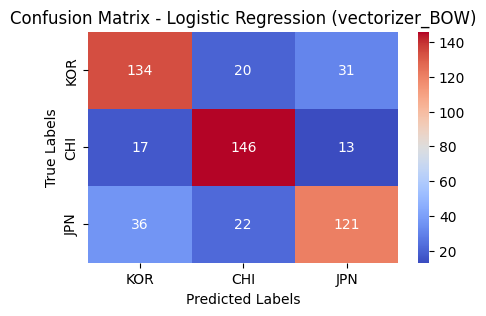

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer() =========================
Logistic Regression (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.7574
- Precision (Macro): 0.7589
- Recall (Macro): 0.7587
- F1 (Macro): 0.7560

Logistic Regression (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  KOR   0.742857 0.702703  0.722222
  CHI   0.747573 0.875000  0.806283
  JPN   0.786164 0.698324  0.739645


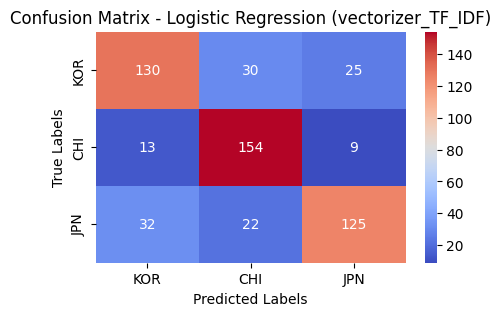

========================= Model: Logistic Regression; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.7889
- Precision (Macro): 0.7885
- Recall (Macro): 0.7899
- F1 (Macro): 0.7891

Logistic Regression (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  KOR   0.752747 0.740541  0.746594
  CHI   0.846995 0.880682  0.863510
  JPN   0.765714 0.748603  0.757062


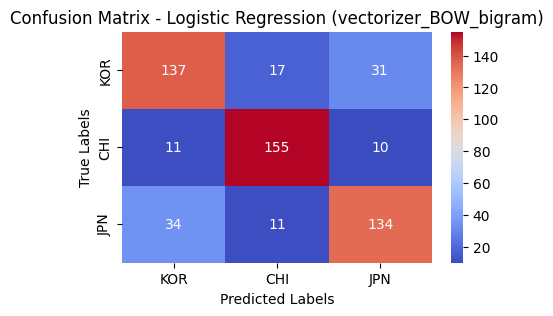

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.7926
- Precision (Macro): 0.7946
- Recall (Macro): 0.7938
- F1 (Macro): 0.7919

Logistic Regression (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  KOR   0.777143 0.735135  0.755556
  CHI   0.773399 0.892045  0.828496
  JPN   0.833333 0.754190  0.791789


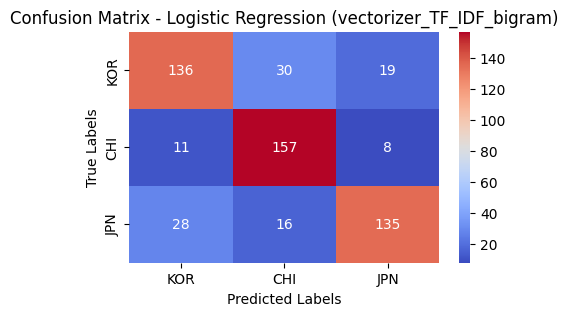

========================= Model: SVM; vectorizer: CountVectorizer() =========================
SVM (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.6778
- Precision (Macro): 0.6751
- Recall (Macro): 0.6797
- F1 (Macro): 0.6761

SVM (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  KOR   0.634731 0.572973  0.602273
  CHI   0.729592 0.812500  0.768817
  JPN   0.661017 0.653631  0.657303


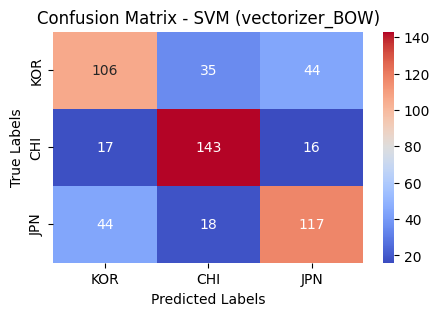

========================= Model: SVM; vectorizer: TfidfVectorizer() =========================
SVM (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.7444
- Precision (Macro): 0.7448
- Recall (Macro): 0.7455
- F1 (Macro): 0.7438

SVM (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  KOR   0.708791 0.697297  0.702997
  CHI   0.760204 0.846591  0.801075
  JPN   0.765432 0.692737  0.727273


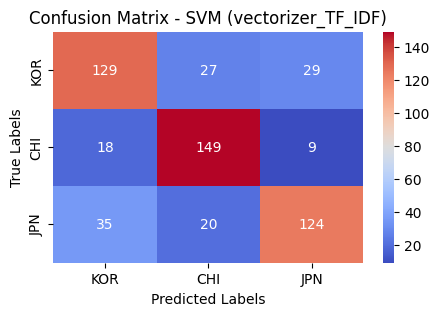

========================= Model: SVM; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.7037
- Precision (Macro): 0.7027
- Recall (Macro): 0.7053
- F1 (Macro): 0.7032

SVM (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  KOR   0.647727 0.616216  0.631579
  CHI   0.740933 0.812500  0.775068
  JPN   0.719298 0.687151  0.702857


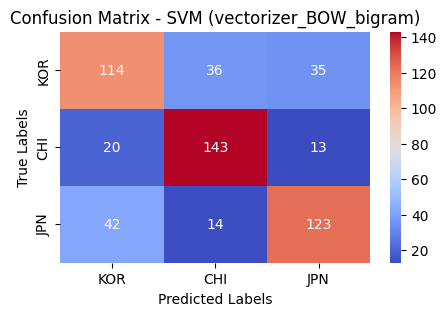

========================= Model: SVM; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.7537
- Precision (Macro): 0.7576
- Recall (Macro): 0.7547
- F1 (Macro): 0.7535

SVM (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  KOR   0.705882 0.713514  0.709677
  CHI   0.750000 0.852273  0.797872
  JPN   0.816993 0.698324  0.753012


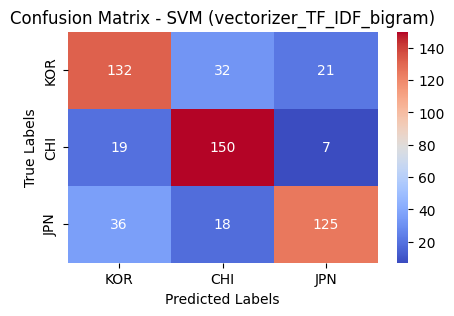

In [68]:
models_g2 = {}
mapping_list2 = {'KOR':0, 'CHI':1, 'JPN':2}
train_1_group(mapping_list2, df_g2, models_g2) # mapping is done here

### cross

In [69]:
dict_df2 = create_1_group_dataframes(balanced_df, {'KOR', 'CHI', "JAP"})

In [70]:
results = cross_validation_1group(dict_df2, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.855
Test Accuracy= 0.865
time spent=0.021585396925608315
2
Dev Accuracy= 0.795
Test Accuracy= 0.835
time spent=0.018225065867106118
{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='saga')
1
Dev Accuracy= 0.855
Test Accuracy= 0.865
time spent=0.02854226032892863
2
Dev Accuracy= 0.795
Test Accuracy= 0.845
time spent=0.02039146820704142
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.87
Test Accuracy= 0.875
time spent=0.019920857747395833
2
Dev Accuracy= 0.825
Test Accuracy= 0.855
time spent=0.016640488306681314
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='saga

In [71]:
best_accuracy_key = best(results)

In [72]:
best_accuracy_key

"{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}"

In [73]:
results[best_accuracy_key]

{'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
 'vectorizer': CountVectorizer(ngram_range=(1, 2)),
 'dev_mean_accuracy': 0.8474999999999999,
 'test_accuracy': 0.865}

In [74]:
# cross validation model
M_G2 = results[best_accuracy_key]["model"]
V_G2 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G2, V_G1, "M_G2", "V_G2")

In [75]:
results[best_accuracy_key]['test_accuracy']

0.865

## Model for  Groupe 3 'FRE+SPA+ITA+'GER'



In [76]:
df_g3 = extract_group(df, 'FRE+SPA+ITA+GER')

In [77]:
df_g3.head()

,0,country_code,text,group
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...,FRE+SPA+ITA+GER
5,"(SPA) In my opinion , travel in group with a t...",SPA,"In my opinion , travel in group with a tour g...",FRE+SPA+ITA+GER
6,(GER) I thing the statement '' Young people no...,GER,I thing the statement '' Young people nowaday...,FRE+SPA+ITA+GER
7,(GER) Whether or not young people enjoy life m...,GER,Whether or not young people enjoy life more t...,FRE+SPA+ITA+GER
12,"(FRE) All along the day , we are surrounded by...",FRE,"All along the day , we are surrounded by cars...",FRE+SPA+ITA+GER


#### train

(3600,)
(3600,)
========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================
Logistic Regression (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.7639
- Precision (Macro): 0.7672
- Recall (Macro): 0.7641
- F1 (Macro): 0.7646

Logistic Regression (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  FRE   0.711957 0.752874  0.731844
  SPA   0.712821 0.776536  0.743316
  ITA   0.795455 0.744681  0.769231
  GER   0.848485 0.782123  0.813953


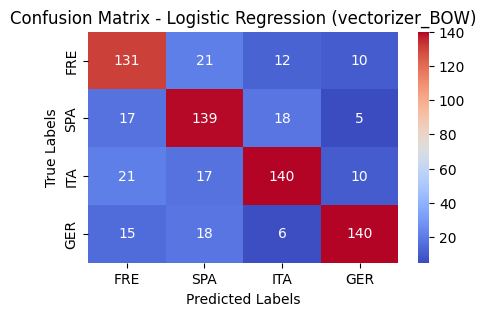

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer() =========================
Logistic Regression (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.7847
- Precision (Macro): 0.7881
- Recall (Macro): 0.7848
- F1 (Macro): 0.7854

Logistic Regression (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  FRE   0.786982 0.764368  0.775510
  SPA   0.698020 0.787709  0.740157
  ITA   0.827586 0.765957  0.795580
  GER   0.840000 0.821229  0.830508


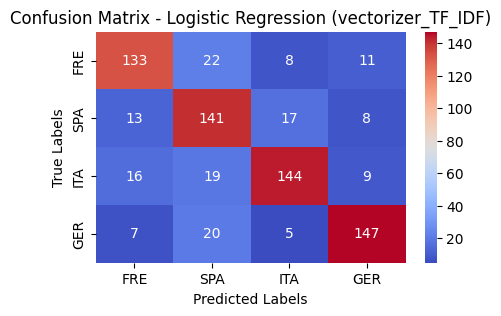

========================= Model: Logistic Regression; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.8056
- Precision (Macro): 0.8077
- Recall (Macro): 0.8057
- F1 (Macro): 0.8060

Logistic Regression (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  FRE   0.756906 0.787356  0.771831
  SPA   0.756477 0.815642  0.784946
  ITA   0.835227 0.781915  0.807692
  GER   0.882353 0.837989  0.859599


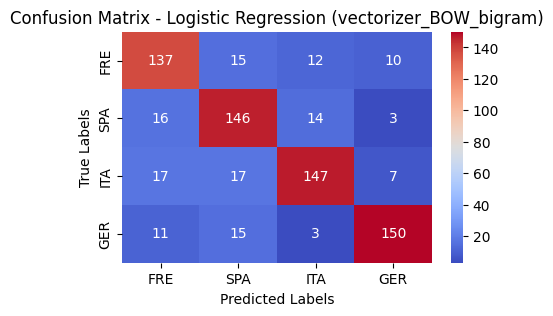

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.7931
- Precision (Macro): 0.7926
- Recall (Macro): 0.7933
- F1 (Macro): 0.7928

Logistic Regression (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  FRE   0.794286 0.798851  0.796562
  SPA   0.735955 0.731844  0.733894
  ITA   0.806630 0.776596  0.791328
  GER   0.833333 0.865922  0.849315


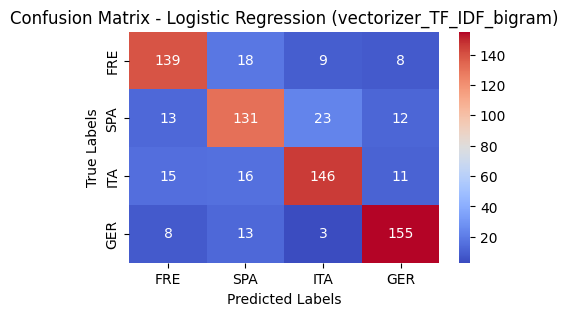

========================= Model: SVM; vectorizer: CountVectorizer() =========================
SVM (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.6806
- Precision (Macro): 0.6842
- Recall (Macro): 0.6805
- F1 (Macro): 0.6812

SVM (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  FRE   0.617347 0.695402  0.654054
  SPA   0.647727 0.636872  0.642254
  ITA   0.695187 0.691489  0.693333
  GER   0.776398 0.698324  0.735294


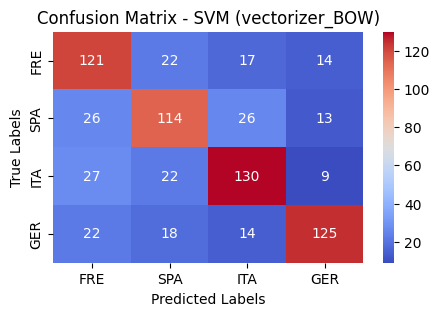

========================= Model: SVM; vectorizer: TfidfVectorizer() =========================
SVM (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.7875
- Precision (Macro): 0.7917
- Recall (Macro): 0.7882
- F1 (Macro): 0.7888

SVM (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  FRE   0.782123 0.804598  0.793201
  SPA   0.695000 0.776536  0.733509
  ITA   0.813953 0.744681  0.777778
  GER   0.875740 0.826816  0.850575


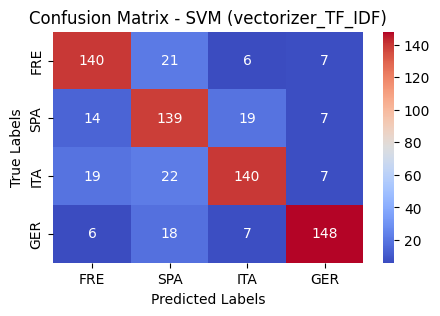

========================= Model: SVM; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.7069
- Precision (Macro): 0.7106
- Recall (Macro): 0.7071
- F1 (Macro): 0.7079

SVM (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  FRE   0.659686 0.724138  0.690411
  SPA   0.666667 0.670391  0.668524
  ITA   0.703704 0.707447  0.705570
  GER   0.812500 0.726257  0.766962


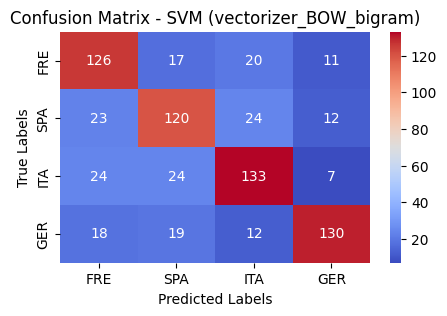

========================= Model: SVM; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.7736
- Precision (Macro): 0.7738
- Recall (Macro): 0.7742
- F1 (Macro): 0.7737

SVM (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  FRE   0.767956 0.798851  0.783099
  SPA   0.708791 0.720670  0.714681
  ITA   0.794286 0.739362  0.765840
  GER   0.824176 0.837989  0.831025


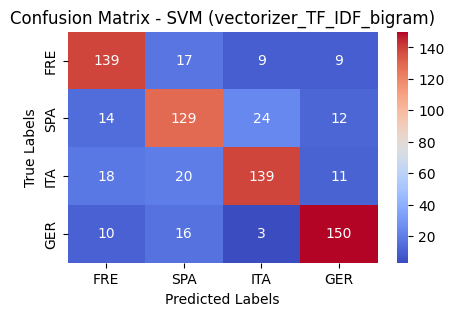

In [78]:
models_g3 = {}
mapping_list3 = {'FRE':0,'SPA':1,'ITA':2, 'GER':3 }
train_1_group(mapping_list3, df_g3, models_g3) # mapping is done here

### cross

In [79]:
dict_df3 = create_1_group_dataframes(balanced_df, {'FRE', 'SPA', "ITA", "GER"})

In [80]:
results = cross_validation_1group(dict_df3, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.755
Test Accuracy= 0.7675
time spent=0.030083068211873374
2
Dev Accuracy= 0.6775
Test Accuracy= 0.665
time spent=0.019269688924153646
{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='saga')
1
Dev Accuracy= 0.755
Test Accuracy= 0.7675
time spent=0.05135042667388916
2
Dev Accuracy= 0.6725
Test Accuracy= 0.6575
time spent=0.028698702653249104
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.77
Test Accuracy= 0.79
time spent=0.032946550846099855
2
Dev Accuracy= 0.7
Test Accuracy= 0.7025
time spent=0.02344961166381836
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='s

In [81]:
best_accuracy_key = best(results)

In [82]:
best_accuracy_key

"{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}"

In [83]:
results[best_accuracy_key]

{'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
 'vectorizer': CountVectorizer(ngram_range=(1, 2)),
 'dev_mean_accuracy': 0.735,
 'test_accuracy': 0.7462500000000001}

In [84]:
# cross validation model
M_G3 = results[best_accuracy_key]["model"]
V_G3 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G3, V_G3, "M_G3", "V_G3")

In [85]:
results[best_accuracy_key]['test_accuracy']

0.7462500000000001

## Model for  Groupe 4 ARA+TUR

In [86]:
df_g4 = extract_group(df, 'ARA+TUR')

In [87]:
df_g4.head()

,0,country_code,text,group
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you...",ARA+TUR
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...,ARA+TUR
13,(TUR) Help of the young people to their commun...,TUR,Help of the young people to their communities...,ARA+TUR
17,(ARA) No body can deny that there are primary ...,ARA,No body can deny that there are primary facto...,ARA+TUR
20,(TUR) Day by day the world getting global the ...,TUR,Day by day the world getting global the peopl...,ARA+TUR


#### train

(1800,)
(1800,)
========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================
Logistic Regression (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.8472
- Precision (Macro): 0.8483
- Recall (Macro): 0.8477
- F1 (Macro): 0.8472

Logistic Regression (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  ARA   0.824468 0.875706  0.849315
  TUR   0.872093 0.819672  0.845070


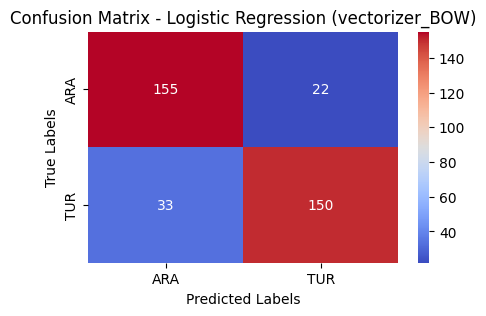

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer() =========================
Logistic Regression (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.8694
- Precision (Macro): 0.8694
- Recall (Macro): 0.8695
- F1 (Macro): 0.8694

Logistic Regression (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  ARA   0.861111 0.875706  0.868347
  TUR   0.877778 0.863388  0.870523


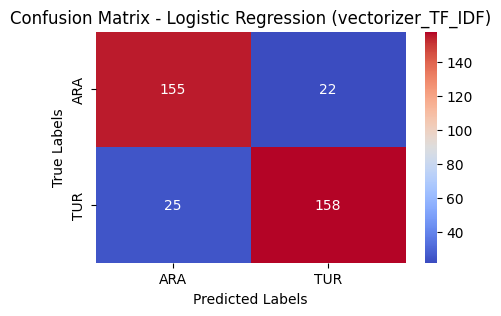

========================= Model: Logistic Regression; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.8944
- Precision (Macro): 0.8954
- Recall (Macro): 0.8949
- F1 (Macro): 0.8944

Logistic Regression (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  ARA   0.871658 0.920904  0.895604
  TUR   0.919075 0.868852  0.893258


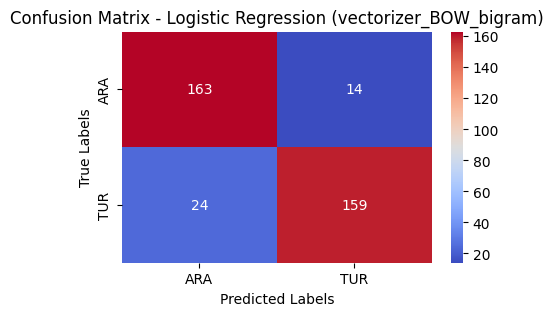

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.8833
- Precision (Macro): 0.8847
- Recall (Macro): 0.8839
- F1 (Macro): 0.8833

Logistic Regression (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  ARA   0.857143 0.915254  0.885246
  TUR   0.912281 0.852459  0.881356


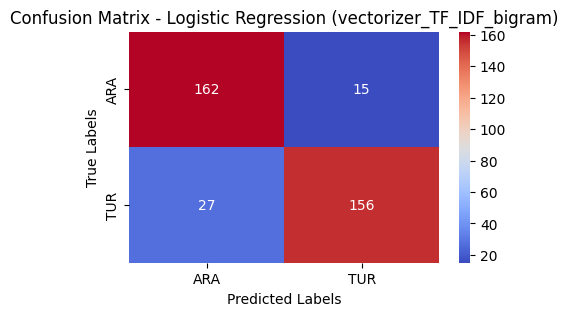

========================= Model: SVM; vectorizer: CountVectorizer() =========================
SVM (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.8583
- Precision (Macro): 0.8585
- Recall (Macro): 0.8585
- F1 (Macro): 0.8583

SVM (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  ARA   0.846154 0.870056  0.857939
  TUR   0.870787 0.846995  0.858726


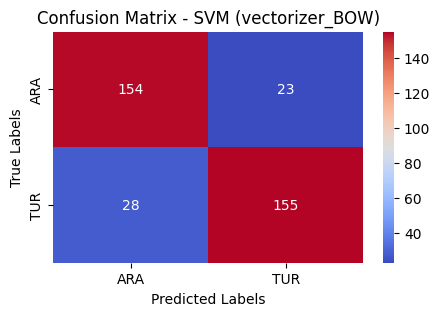

========================= Model: SVM; vectorizer: TfidfVectorizer() =========================
SVM (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.8944
- Precision (Macro): 0.8945
- Recall (Macro): 0.8946
- F1 (Macro): 0.8944

SVM (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  ARA   0.883978 0.903955  0.893855
  TUR   0.905028 0.885246  0.895028


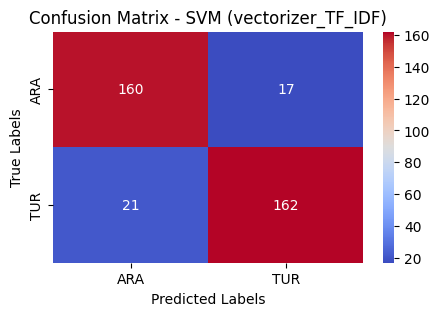

========================= Model: SVM; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.8472
- Precision (Macro): 0.8474
- Recall (Macro): 0.8474
- F1 (Macro): 0.8472

SVM (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  ARA   0.835165 0.858757  0.846797
  TUR   0.859551 0.836066  0.847645


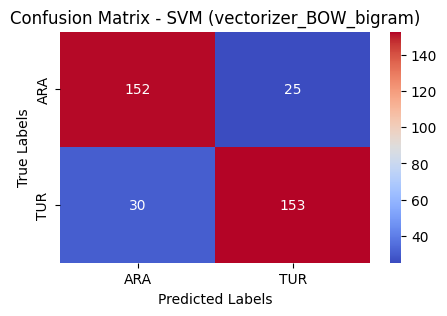

========================= Model: SVM; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.8944
- Precision (Macro): 0.8954
- Recall (Macro): 0.8949
- F1 (Macro): 0.8944

SVM (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  ARA   0.871658 0.920904  0.895604
  TUR   0.919075 0.868852  0.893258


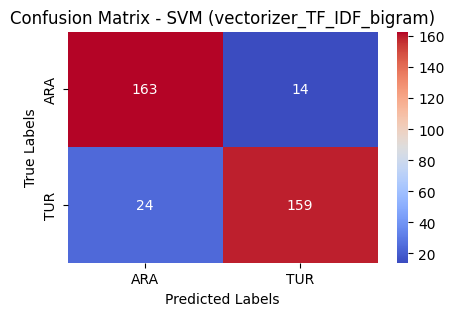

In [88]:
models_g4 = {}
mapping_list4 = {'ARA':0,'TUR':1}
train_1_group(mapping_list4, df_g4, models_g4) # mapping is done here

### cross

In [89]:
dict_df4 = create_1_group_dataframes(balanced_df, {'ARA', 'TUR'})

In [90]:
results = cross_validation_1group(dict_df4, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.885
Test Accuracy= 0.865
time spent=0.03072623411814372
2
Dev Accuracy= 0.835
Test Accuracy= 0.885
time spent=0.025977106889088948
{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='saga')
1
Dev Accuracy= 0.885
Test Accuracy= 0.865
time spent=0.04681634505589803
2
Dev Accuracy= 0.83
Test Accuracy= 0.885
time spent=0.03819986581802368
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.9
Test Accuracy= 0.865
time spent=0.035810661315917966
2
Dev Accuracy= 0.855
Test Accuracy= 0.9
time spent=0.027947513262430827
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='saga')
1


In [91]:
best_accuracy_key = best(results)

In [92]:
best_accuracy_key

"{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}"

In [93]:
results

{"{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.86,
  'test_accuracy': 0.875},
 "{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.8574999999999999,
  'test_accuracy': 0.875},
 "{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.8775,
  'test_accuracy': 0.8825000000000001},
 "{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=

In [94]:
results[best_accuracy_key]

{'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
 'vectorizer': CountVectorizer(ngram_range=(1, 2)),
 'dev_mean_accuracy': 0.8825000000000001,
 'test_accuracy': 0.89}

In [95]:
# cross validation model
M_G4 = results[best_accuracy_key]["model"]
V_G4 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G4, V_G4, "M_G4", "V_G4")

In [96]:
results

{"{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.86,
  'test_accuracy': 0.875},
 "{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.8574999999999999,
  'test_accuracy': 0.875},
 "{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=(1, 2)),
  'dev_mean_accuracy': 0.8775,
  'test_accuracy': 0.8825000000000001},
 "{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}": {'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
  'vectorizer': CountVectorizer(ngram_range=